In [1]:
import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams["font.size"] = 22
plt.rcParams['axes.facecolor'] = 'white'

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.metrics import classification_report, roc_auc_score

import uproot 
import awkward as ak


In [2]:
file = "/home/dejavu/Projects/qgcal/Sample_inspect/dijets_manual.npy"
dijets = np.load(file)

In [3]:
branch_names = ["jet_pt", "jet_eta", "jet_nTracks", "jet_trackWidth", "jet_trackC1", "jet_trackBDT", "jet_PartonTruthLabelID", "total_weight"]
dijets.shape

(141780524, 8)

In [4]:
large_weight_idx = np.where(np.abs(dijets[:,-1]) > 100)[0]
dijets[:,-1][large_weight_idx] = 1.0

In [5]:
dijets[:, ]
gluon_idx = np.where(dijets[:,-2]==21)[0]
light_quark_idx = np.where((dijets[:,-2]==0) | (dijets[:,-2]==1)| (dijets[:,-2]==2))[0]
gluon = dijets[gluon_idx]
quark = dijets[light_quark_idx]

In [6]:
gluon.shape

(67618360, 8)

In [7]:
quark.shape

(64582119, 8)

In [8]:
gluon_df = pd.DataFrame(gluon, columns = branch_names)
quark_df = pd.DataFrame(quark, columns = branch_names)
# write_file = uproot.recreate("dijets_manual.root")
# write_file["TreeGluon"] = gluon_df
# write_file["TreeQuark"] = quark_df
# write_file.close()

In [9]:
gluon_df.head()

,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,total_weight
0,5.139873e+05,-0.106736,23.0,0.056083,0.249986,0.175032,21.0,1.0
1,5.039162e+05,-1.689755,21.0,0.075387,0.251628,0.084369,21.0,1.0
2,9.801305e+04,1.657701,9.0,0.042900,0.185697,-0.144684,21.0,1.0
3,6.228642e+05,0.157243,8.0,0.005913,0.144498,-0.522744,21.0,1.0
4,2.359833e+06,0.679000,9.0,0.010928,0.121194,-0.567144,21.0,1.0


In [10]:
quark_df.head()

,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,total_weight
0,1.255107e+05,1.935292,21.0,0.153218,0.333217,0.296163,1.0,1.000000
1,4.883089e+05,-0.930501,14.0,0.110542,0.292682,-0.058424,2.0,1.000000
2,2.751357e+06,0.168292,7.0,0.021723,0.073639,-0.556484,1.0,1.000000
3,4.315441e+05,0.097180,14.0,0.032487,0.226235,0.026688,2.0,28.393007
4,4.023938e+05,-2.036458,19.0,0.056825,0.264194,0.144467,2.0,28.393007


In [10]:
X = np.concatenate((quark[:,:5], gluon[:,:5]), axis=0)
y = np.concatenate((-1.0 * np.ones(light_quark_idx.shape[0]), 1.0 * np.ones(gluon_idx.shape[0])))

In [16]:
nevents = 100000
X = np.concatenate((quark[:nevents,np.r_[:5, 7]], gluon[:nevents,np.r_[:5, 7]]), axis=0)
# y = np.concatenate((np.zeros(nevents), np.ones(nevents)))
y = np.concatenate((-1.0 * np.ones(nevents), 1.0 * np.ones(nevents)))

In [17]:
from sklearn.model_selection import train_test_split

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

dt = DecisionTreeClassifier(max_depth=5,
                            min_samples_leaf=0.002,
                            max_features="log2")
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME.R',
                         n_estimators=800,
                         learning_rate=0.001)

In [19]:
len(X_train)

160000

In [20]:
bdt.fit(X_train[:, :5], y_train, sample_weight=X_train[:,-1])

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                         max_features='log2',
                                                         min_samples_leaf=0.002),
                   learning_rate=0.001, n_estimators=800)

In [21]:
y_test_predicted = bdt.predict(X_test[:,:5])
y_test_predicted_proba = bdt.predict_proba(X_test[:,:5])
y_test_decisions = bdt.decision_function(X_test[:,:5])

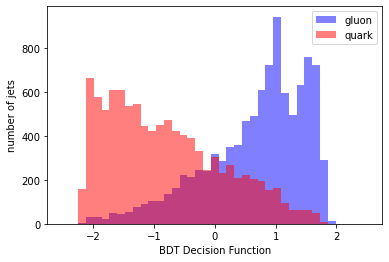

In [34]:
y_test_gluon_id = np.where(y_test==1)[0]
y_test_quark_id = np.where(y_test==-1)[0]
bins_scores = np.linspace(-2.5, 2.5, 40)
plt.hist(y_test_decisions[y_test_gluon_id], bins_scores, alpha=0.5, label='gluon', color = 'blue')
plt.hist(y_test_decisions[y_test_quark_id], bins_scores, alpha=0.5, label='quark', color = 'red')
plt.legend(loc='upper right')
plt.xlabel("BDT Decision Function")
plt.ylabel("number of jets")
plt.show()

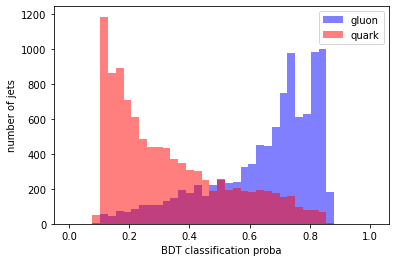

In [35]:
y_test_gluon_id = np.where(y_test==1)[0]
y_test_quark_id = np.where(y_test==-1)[0]
bins_scores = np.linspace(-0.0, 1.01, 40)
plt.hist(y_test_predicted_proba[:,1][y_test_gluon_id], bins_scores, alpha=0.5, label='gluon', color = 'blue')
plt.hist(y_test_predicted_proba[:,1][y_test_quark_id], bins_scores, alpha=0.5, label='quark', color = 'red')
plt.legend(loc='upper right')
plt.xlabel("BDT classification proba")
plt.ylabel("number of jets")
plt.show()

In [36]:
y_predicted = bdt.predict(X_test[:,:5])
print(classification_report(y_test, y_predicted,
                            target_names=["background", "signal"]))
print("Area under ROC curve: %.4f"%(roc_auc_score(y_test,
                                                  bdt.decision_function(X_test[:,:5]))))

              precision    recall  f1-score   support

  background       0.80      0.79      0.79     10102
      signal       0.79      0.80      0.79      9898

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000

Area under ROC curve: 0.8719


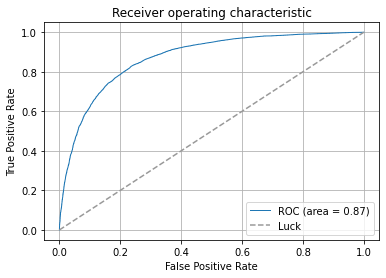

In [37]:
from sklearn.metrics import roc_curve, auc

decisions = bdt.decision_function(X_test[:,:5])
# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, decisions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

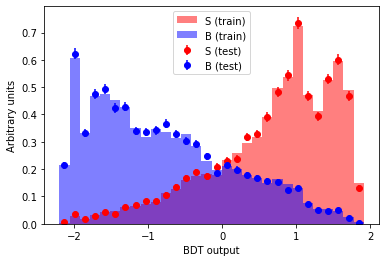

In [38]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
compare_train_test(bdt, X_train[:,:5], y_train, X_test[:,:5], y_test)

# Questions 
1. TMVA BDT Score -> prob or decision function?
2. Based on the description of decision function, why the boundary is not (-1, 1)?
``` Python
    def decision_function(self, X):
        """Compute the decision function of ``X``.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Sparse matrix can be CSC, CSR, COO,
            DOK, or LIL. COO, DOK, and LIL are converted to CSR.

        Returns
        -------
        score : ndarray of shape of (n_samples, k)
            The decision function of the input samples. The order of
            outputs is the same of that of the :term:`classes_` attribute.
            Binary classification is a special cases with ``k == 1``,
            otherwise ``k==n_classes``. For binary classification,
            values closer to -1 or 1 mean more like the first or second
            class in ``classes_``, respectively.
        """
```

3. `max_features="log2"` is important to get meaningful results. Double check with TMVA. 
4. Update the weights. 


# Reference
1. [ scikit-learn for TMVA Users ](https://betatim.github.io/posts/sklearn-for-TMVA-users/)
2. [ Advanced scikit-learn for TMVA Users ](https://betatim.github.io/posts/advanced-sklearn-for-TMVA/)
3. [ Uproot tutorial ](https://masonproffitt.github.io/uproot-tutorial/)

# Regression Tree(problematic)

In [29]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=3, min_samples_split=0.002, max_features="log2")
bdt = AdaBoostRegressor(dt,
                        n_estimators=600,
                        learning_rate=0.00001,
                        loss="square")

In [30]:
bdt.fit(X_train[:, :5], y_train, sample_weight=X_train[:,-1])

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3,
                                                       max_features='log2',
                                                       min_samples_split=0.002),
                  learning_rate=1e-05, loss='square', n_estimators=600)

In [36]:
y_test.shape

(20000,)

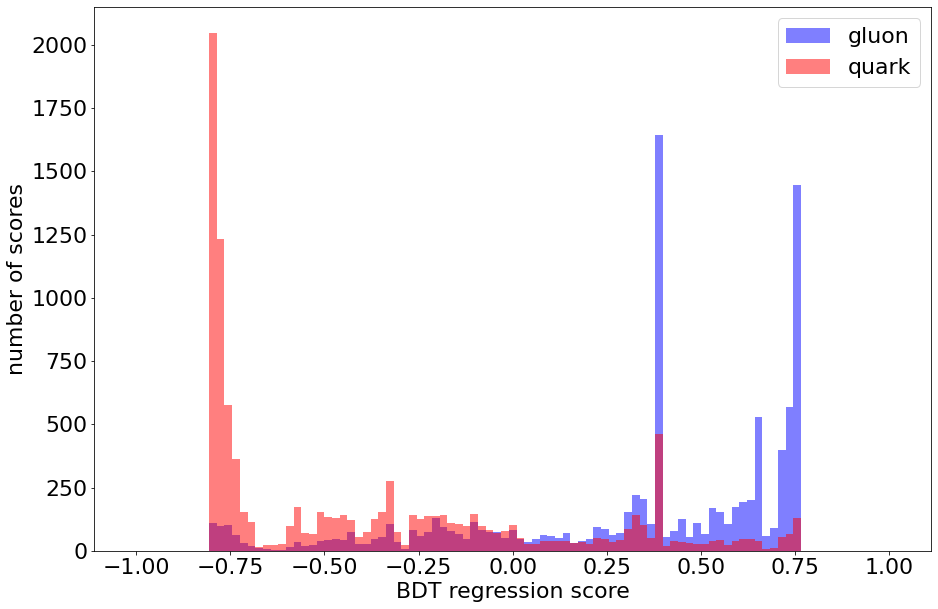

In [39]:
y_test_predicted = bdt.predict(X_test[:,:5])
y_test_gluon_id = np.where(y_test==1)[0]
y_test_quark_id = np.where(y_test==-1)[0]
bins_scores = np.linspace(-1.01, 1.01, 100)
plt.hist(y_test_predicted[y_test_gluon_id], bins_scores, alpha=0.5, label='gluon', color = 'blue')
plt.hist(y_test_predicted[y_test_quark_id], bins_scores, alpha=0.5, label='quark', color = 'red')
plt.legend(loc='upper right')
plt.xlabel("BDT regression score")
plt.ylabel("number of scores")
plt.show()

In [33]:
np.unique(y_test_predicted).shape

(3167,)